### Python Preamble

In [1]:
# Analysis of Disulfide Bonds in Proteins of Known Structure 
# Author: Eric G. Suchanek, PhD.
# Last revision: 1/19/23 -egs-
# Cα Cβ Sγ

import math
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import plotly_express as px
#import seaborn as sns

import proteusPy
from proteusPy import *
from proteusPy.Disulfide import *

from proteusPy.ProteusGlobals import *

import pandas as pd
import pyvista as pv
from pyvista import set_plot_theme

plt.style.use('dark_background')

# ipyvtklink
#pv.set_jupyter_backend('ipyvtklink')

set_plot_theme('document')

# the locations below represent the actual location on the dev drive.
# location for PDB repository
PDB_BASE = '/Users/egs/PDB/'

# location of cleaned PDB files
PDB = '/Users/egs/PDB/good/'

# location of the compressed Disulfide .pkl files
MODELS = f'{PDB_BASE}models/'


## Analysis of Disulfide Bonds in Proteins Within the RCSB Protein Data Bank
*Eric G. Suchanek, PhD. (suchanek@mac.com)* <br> <br>

## Summary
I describe the results of a structural analysis of Disulfide bonds contained in 36,362 proteins within the RCSB Protein databank, https://www.rcsb.org. These protein structures contained 291,274 Disulfide Bonds.  The analysis utilizes Python functions from my ``ProteusPy`` package https://github.com/suchanek/proteusPy/, which is built upon the excellent ``BioPython`` library (https://www.biopython.org). 

This work represents a reprise of my original Disulfide modeling analysis conducted in 1986 ([publications](#publications) item 1) as part of my dissertation. Given the original Disulfide database contained only 2xx Disulfide Bonds I felt it would be interesting to revisit the RCSB and mine the thousands of new structures. The initial results are described in the cells below.

### Requirements
 - Biopython patched version, or my delta applied, available at: https://github.com/suchanek/bio/
 - proteusPy: https://github.com/suchanek/proteusPy/

## Introduction
Disulfide bonds are important covalent stabilizing elements in proteins. They are formed when two Sulphur-containing Cysteine (Cys) amino acid residues are close enough and in the correct geometry to form a S-S covalent bond with their terminal sidechain Sγ atoms. Disulfide bonds most commonly occur between alpha helices and greatly enhance a protein's stability to denaturation. 


## Download PDB Files containing Disulfide Bonds

The RCSB query yielded 

In [2]:

# Download_Disulfides(pdb_home=PDB_BASE, model_home=MODELS, reset=False)


## Extract the Disulfides from the PDB files
The function ``Extract_Disulfides()`` processes all the .ent files in ``PDB_DIR`` and creates two .pkl files representing the Disulfide bonds contained in the scanned directory. In addition, a .csv file containing problem IDs is written if any are found. The .pkl files are consumed by the ``DisulfideLoader`` class and are considered private. You'll see numerous warnings during the scan. Files that are unparsable are removed and their IDs are logged to the problem_id.csv file. The default file locations are stored in the file globals.py and are the used by ``DisulfideExtractor()`` in the absence of arguments passed. The Disulfide parser is very stringent and will reject disulfide bonds with missing atoms or disordered atoms.


Outputs are saved in ``MODEL_DIR``:
1) ``SS_PICKLE_FILE``: The ``DisulfideList`` of ``Disulfide`` objects initialized from the PDB file scan, needed by the ``DisulfideLoader()`` class.
2) ``SS_DICT_PICKLE_FILE``: the ``Dict Disulfide`` objects also needed by the ``DisulfideLoader()`` class
3) ``PROBLEM_ID_FILE``: a .csv containining the problem ids.

In general, the process only needs to be run once for a full scan. Setting the ``numb`` argument to -1 scans the entire directory. Entering a positive number allows parsing a subset of the dataset, which is useful when debugging. Setting ``verbose`` enables verbose messages. Setting ``quiet`` to ``True`` disables all warnings.

NB: A extraction of the initial disulfide bond-containing files (> 36000 files) takes about 1.25 hours on a 2020 MacbookPro with M1 Pro chip, 16GB RAM, 1TB SSD. The resulting .pkl files consume approximately 1GB of disk space, and equivalent RAM used when loaded.

In [3]:


#Extract_Disulfides(numb=5000, pdbdir=PDB, datadir=MODELS, verbose=False, quiet=True)


## Load the Disulfide Data
Now that the Disulfides have been extracted and the Disulfide .pkl files have been created we can load them into memory using the DisulfideLoader() class. This class stores the Disulfides internally as a DisulfideList and a dict. Array indexing operations including slicing have been overloaded, enabling straightforward access to the Disulfide bonds, both in aggregate and by residue. After loading the .pkl files the Class creates a Pandas ``DataFrame`` object consisting of the Disulfide ID, all sidechain dihedral angles, the local coordinates for the Disulfide and the computed Disulfide bond torsional energy.

NB: Loading the data takes 3.5 minutes on my MacbookPro. Be patient if it seems to take a long time to load.

In [4]:
# when running from the repo the local copy of the Disulfides is in proteusPy/data
# the locations below represent the actual location on the dev drive.
# location for PDB repository
# takes 
PDB_BASE = '/Users/egs/PDB/'

# location of the compressed Disulfide .pkl files. Currently I don't have the entire
# dataset in the repo, so to load the full dataset I point to my dev drive

DATA = f'{PDB_BASE}data/'

PDB_SS = DisulfideLoader(verbose=True, subset=True, datadir=DATA)


Reading disulfides from: /Users/egs/PDB/data/PDB_subset_ss.pkl
Disulfides Read: 8210
Reading disulfide dict from: /Users/egs/PDB/data/PDB_subset_ss_dict.pkl
Reading Torsion DF /Users/egs/PDB/data/PDB_subset_SS_torsions.csv.
Read torsions DF.
PDB IDs parsed: 1000
Total Space Used: 2034997 bytes.


In [ ]:
#print(pv.Report())

The Disulfide and DisulfideList classes include rendering capabiities using the excellent PyVista interface to the VTK package. (http://pyvista.org). The following cell displays the first Disulfide bond in the database in ball-and stick style. Atoms are colored by atom type:
- Grey = Carbon
- Blue = Nitrogen
- Red = Oxygen
- Yellow = Sulfur
- White = Previous residue carbonyl carbon and next residue amino Nitrogen. (more on this below).

The display is actually interactive. Select drag to rotate, mousewheel to zoom. The X-Y-Z widget in the window upper right allows orientation against the X, Y and Z axes.

In [ ]:
ss = PDB_SS[0]
ss.display(style='cpk')

The ```Disulfide``` and ```DisufideLoader``` classes can render Disulfides and DisulfideLists in several molecular styles

In [ ]:
ss.display(style='sb')

## Examine the Disulfide $C_\alpha-C_\alpha$ Distances
The Disulfide Bond $Cα-Cα$ distances are constrained due to the bond lengths and bond angles of the disulfide bond itself. We can get an overall sense of the protein structure data quality by looking at the distance distribution and removing any disulfides that have unreasonable/physically impossible distances.

In [7]:
#
#
# retrieve the torsions dataframe
from proteusPy.Disulfide import Torsion_DF_Cols

_SSdf = PDB_SS.getTorsions()
# there are a few structures with bad SSBonds. Their
# CA distances are > 7.0. We remove them from consideration
# below

_far = _SSdf['ca_distance'] >= 9.0
_near = _SSdf['ca_distance'] < 9.0

SS_df_Far = _SSdf[_far]

# entire database
SS_df = _SSdf[_near]

SS_df = SS_df[Torsion_DF_Cols].copy()
SS_df.describe()


,proximal,distal,chi1,chi2,chi3,chi4,chi5,energy,ca_distance,phi_prox,psi_prox,phi_dist,psi_dist,torsion_length
count,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000
mean,231.278996,280.346979,-46.629686,-4.378927,-4.470057,-25.853331,-27.920738,3.737169,5.614845,-101.591249,69.342563,-98.335094,72.742920,233.897311
std,285.935670,285.021136,103.699711,110.152895,94.099061,112.111871,99.624047,2.347696,0.810671,43.428947,95.401212,42.197039,95.304450,56.420033
min,1.000000,6.000000,-179.990815,-179.990782,-179.502078,-179.940602,-179.999305,0.494753,2.929105,-180.000000,-180.000000,-180.000000,-180.000000,102.031030
25%,44.000000,96.000000,-91.455331,-86.803270,-88.434575,-99.589518,-73.926954,2.066980,5.125790,-131.233155,-17.961409,-124.000628,-14.739779,187.395658
50%,138.000000,195.000000,-64.205495,-54.534344,-64.862906,-69.118129,-59.352974,3.292015,5.702370,-105.335892,115.626869,-100.495110,122.355571,232.813196
75%,324.000000,364.000000,-41.598128,100.995312,93.524929,83.722662,57.698374,4.637476,6.268095,-73.163205,140.632542,-73.911027,144.177815,273.129406
max,5045.000000,5070.000000,179.945970,179.987671,179.976934,179.977181,179.990016,17.289549,8.133121,179.578735,179.972228,179.337160,179.971149,368.022621


The average $C_\alpha$- $C_\alpha$ distance for the entire dataset is 5.62A , with a minimum distance of 2.71 $\AA$ and a maximum of 158.8 $\AA$. Since the latter is not physically possible we should examine the data further to check for additional outliers.

In [ ]:
SS_df_Far.describe()

Only 236 disulfides have distances >= 9 $\AA$. Later we will ignore those and only use the disulfides with < 9 $\AA$. For now let's have a look at the longest disulfide. The ``DisulfideLoader.getTorsions()`` function returns a Dataframe containing these distances. We can sort by distance using Pandas.

In [ ]:
# The distances are held in the overall Torsions array. We get this and sort
distances = PDB_SS.getTorsions()
distances.sort_values(by=['ca_distance'], ascending=False, inplace=True)

distances.head(20)

In [ ]:
#long = PDB_SS.get_by_name('2v0o_147C_273C')
#long.display(style='sb')

In [ ]:
long2 = PDB_SS.get_by_name('4bog_142A_130M')
#long2.display(style='sb')

## Examining Disulfide Energies


In [8]:
labels = {'value': 'Energy', 'variable': 'Count'}
cols = ['energy']
px.histogram(SS_df['energy'], labels=labels, histnorm='probability', template='plotly_dark')


### Find the lowest and highest energy disulfides and display them

In [9]:
# takes 5 min 26 sec

All_SS_list = PDB_SS.SSList

ssMin, ssMax = PDB_SS.SSList.minmax_energy()


In [10]:
ssMin

<Disulfide 1xr9_203A_259A SourceID: 1xr9 Proximal: 203 A Distal: 259 A>

In [11]:
ssMax

<Disulfide 1zjk_629A_660A SourceID: 1zjk Proximal: 629 A Distal: 660 A>

In [12]:
minmaxlist = DisulfideList([ssMin, ssMax], 'minmax')
minmaxlist.display(style='sb')

ViewInteractiveWidget(height=512, layout=Layout(height='auto', width='100%'), width=1024)

The structure above shows that the previous and next residues have missing atoms (the long vectors drawn).

In [ ]:
SS_df = _SSdf[_near]
SS_df = SS_df[Torsion_DF_Cols]

SS_df = SS_df.sort_values(by=['energy'])
ssid_list = SS_df['ss_id'].values

good_SS_list = DisulfideList([],'low_energy')
bad_SS_list = DisulfideList([],'high_energy')

ss = Disulfide()

# first 12 are lowest energy
for i in range(12):
    ssid = ssid_list[i]
    ss = PDB_SS.get_by_name(ssid)
    good_SS_list.append(ss)
    
for i in range(13):
    if i == 0:
        continue
    ssid = ssid_list[-i]
    ss = PDB_SS.get_by_name(ssid)
    bad_SS_list.append(ss)
    


In [ ]:
bad_SS_list.display(style='sb')


#bad_SS_list.display(style='sb')


In [13]:
labels = {'value': 'Ca Distance', 'variable': 'Count'}
cols = ['ca_distance']
data = SS_df[cols].copy()
px.histogram(SS_df['ca_distance'], labels=labels, template='plotly_dark')
#px.histogram(SS_df[cols], labels=labels)


In [15]:
labels = {'value': 'Distance', 'variable': 'Distance'}
cols = ['ca_distance', 'energy']
data = SS_df[cols].copy()
data.set_index('ca_distance')

px.histogram(SS_df, x='chi1', y='chi5', labels=labels, histfunc='avg', nbins=90)
px.histogram(SS_df[cols], labels=labels)


## Examine the Disulfide Torsions
The disulfide bond's overall conformation is defined by the sidechain dihedral angles $\chi_{1}$-$\chi_{5}$. Since the S-S bond has electron delocalization, it exhibits some double-bond character with strong minima at $+90°$ and $-90°$. The *Left-handed* Disulfides have $\chi_{3}$ < 0.0° and the *Right-handed* have a $\chi_{3}$ > 0.0°.

These torsion values along with the approximate torsional energy are stored in the DisulfideLoader() class and individually within each Disulfide object. We access them via the ``DisulfideList.getTorsions()`` function.

We can get a quick look at their overall statistics using the ``Pandas.describe()`` function.



In [16]:
labels = {'value': 'Angle', 'variable': 'Torsion'}
cols = ['chi1', 'chi5']
data = SS_df[cols].copy()
data.set_index('chi1')

px.histogram(SS_df, x='chi1', y='chi5', labels=labels, histfunc='avg', nbins=90)
px.histogram(SS_df[cols], labels=labels)


### Examining torsions by Disulfide Handedness
We split the dataset into these two families easily with Pandas.

In [17]:
# make two dataframes containing left handed and right handed disulfides

_left = SS_df['chi3'] <= 0.0
_right = SS_df['chi3'] > 0.0

# left handed and right handed torsion dataframes
SS_df_Left = SS_df[_left]
SS_df_Right = SS_df[_right]


In [18]:
# routine creates 2 lists  for left-handed and right-handed disulfides 

ss_list = PDB_SS.getlist()
left_handed_SS = DisulfideList([], 'left_handed')
right_handed_SS = DisulfideList([], 'right_handed')

for ss in ss_list:
    if ss.chi3 < 0:
        left_handed_SS.append(ss)
    else:
        right_handed_SS.append(ss)

print(f'Left Handed: {len(left_handed_SS)}, Right Handed: {len(right_handed_SS)}')


Left Handed: 4397, Right Handed: 3813


Test of $ \alpha \AA $

In [ ]:
px.histogram(SS_df, x='chi2', y='chi4', labels=labels, histfunc='avg', nbins=90)

In [19]:
labels2 = {'value': 'Angle', 'variable': 'Distance'}
px.histogram(SS_df, x='ca_distance', labels=labels2, nbins=100)

We can use a hexbin plot to generate the equivalent of a heatmap to explore the symmetry for the Chi1-Chi5 and Chi2-Chi4 dihedral angles. Since the disulfide bond is symmetric about Chi3 (the S-S bond), one would expect the distribution of Chi1 to be similar to Chi5, and the same with Chi2 and Chi4.

In [20]:

# Set the figure sizes and axis limits.
DPI = 220
WIDTH = 6.0
HEIGHT = 3.0
TORMIN = -179.0
TORMAX = 180.0
GRIDSIZE = 20


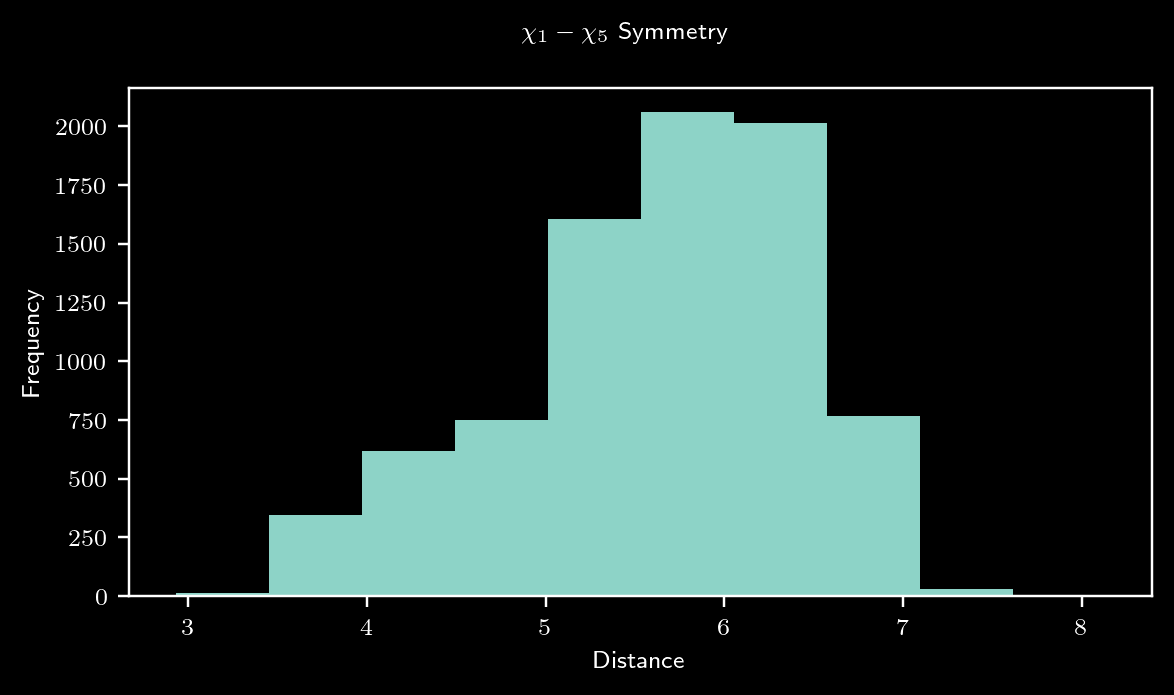

In [21]:
x = SS_df['ca_distance']
plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)
fig.suptitle(r'$\chi_{1} - \chi_{5}$ Symmetry', fontsize=8)

ax1= fig.subplots()
ax1.set_xlabel(r'Distance')
ax1.set_ylabel(r'Frequency')

ax1.hist(x)

plt.show()


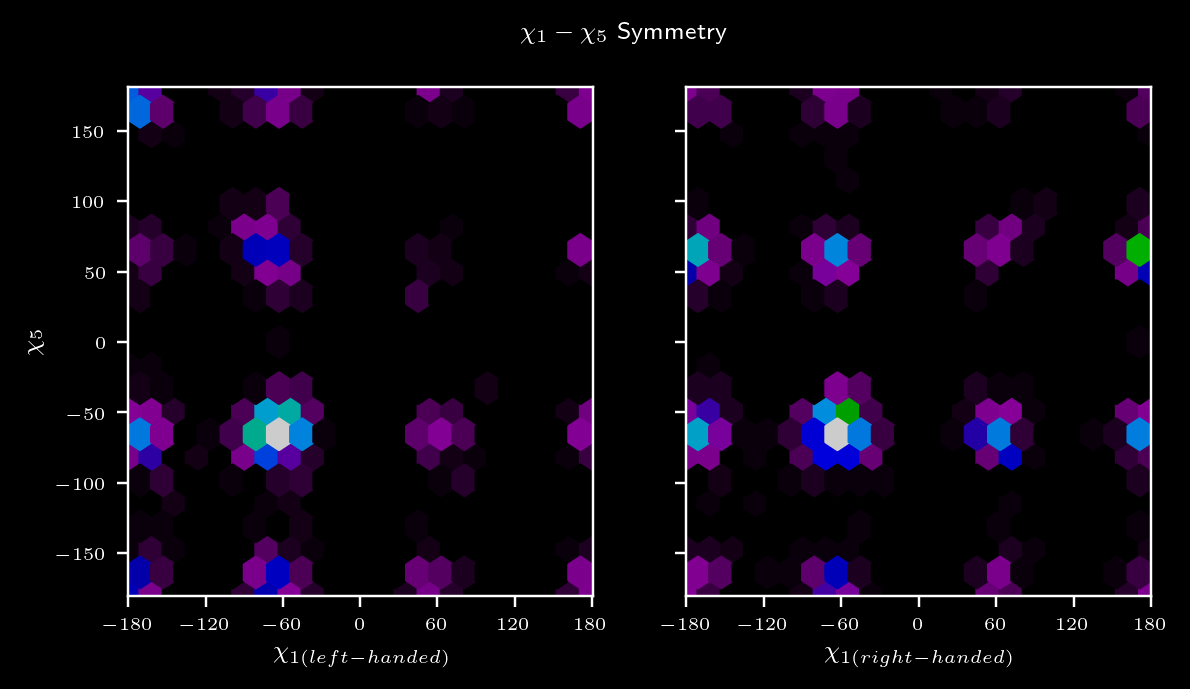

In [22]:
# !!!

x = SS_df_Left['chi1']
y = SS_df_Left['chi5']

x2 = SS_df_Right['chi1']
y2 = SS_df_Right['chi5']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

ax1, ax2 = fig.subplots(1, 2, sharey=True)

fig.suptitle(r'$\chi_{1} - \chi_{5}$ Symmetry', fontsize=8)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)

ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\chi_{1 (left-handed)}$')
ax1.set_ylabel(r'$\chi_{5}$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(TORMIN-1, TORMAX+1)

ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\chi_{1 (right-handed)}$')

ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()



The distributions look extremely similar for both the left-handed and right-handed populations. Let's look at Chi2 and Chi4 to see if this holds true.

In [ ]:
x = SS_df_Left['chi2']
y = SS_df_Left['chi4']

x2 = SS_df_Right['chi2']
y2 = SS_df_Right['chi4']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

fig.suptitle(r'$\chi_{2} - \chi_{4}$ Symmetry', fontsize=8)

ax1, ax2 = fig.subplots(1, 2, sharey=False)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\chi_{2 (left-handed)}$')
ax1.set_ylabel(r'$\chi_{4}$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(-180, 180)
ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\chi_{2 (right-handed)}$')
ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()



The distributions for left/right show distinct differences. Both show the predicted minimum around -75 degrees, but the right-handed group shows a population of disfuldies in the +90 degree range.

In [ ]:
#

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)
ax1 = plt.subplot(111)

x = SS_df['chi3']
y = SS_df['energy']

ymax = 10.0
plt.hexbin(x, y, gridsize=40, cmap='nipy_spectral')
ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(y.min(), ymax)
ax1.set_xlabel(r'$\chi_{3}$')
ax1.set_ylabel(r'Energy kcal/mol')
ax1.set_title(r'Energy vs $\chi_{3}$')
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 30))

plt.show()


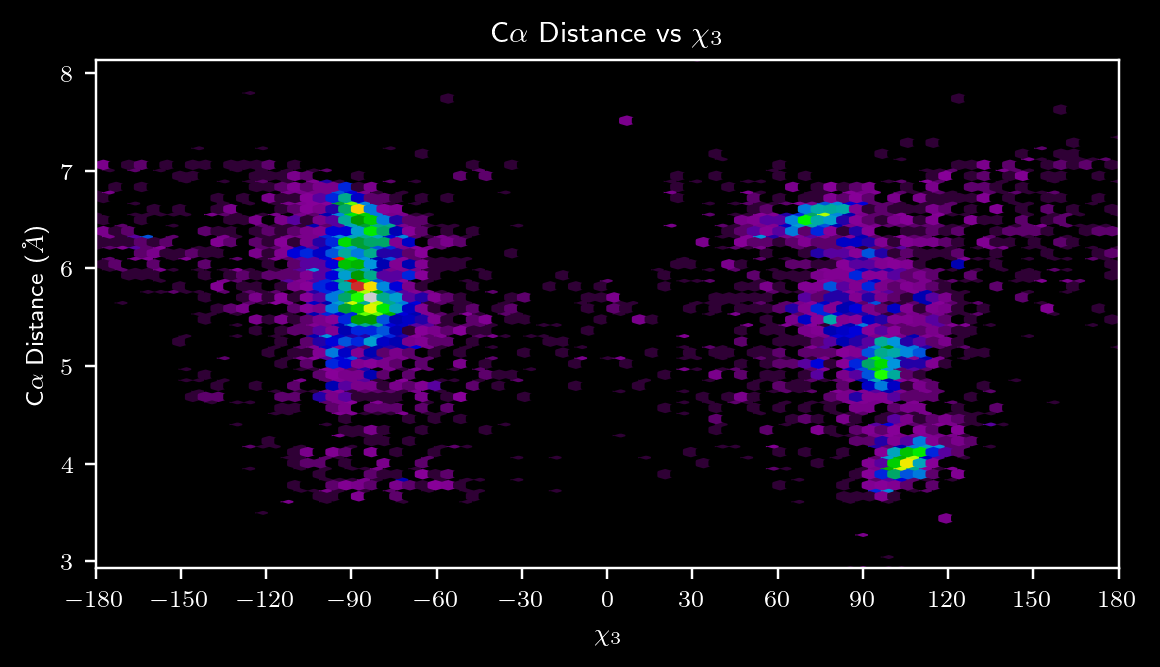

In [23]:
#
TORMAX = 180 # for left handed (Chi3 < 0)
fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)
ax1 = plt.subplot(111)

x = SS_df['chi3']
y = SS_df['ca_distance']

ymax = 8.0
plt.hexbin(x, y, gridsize=80, cmap='nipy_spectral')
ax1.set_xlim(TORMIN-1, TORMAX)
ax1.set_ylim(y.min(), y.max())
ax1.set_xlabel(r'$\chi_{3}$')
ax1.set_ylabel(r'C${\alpha}$ Distance ($\AA$)')
ax1.set_title(r'C${\alpha}$ Distance vs $\chi_{3}$')
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 30))

plt.show()


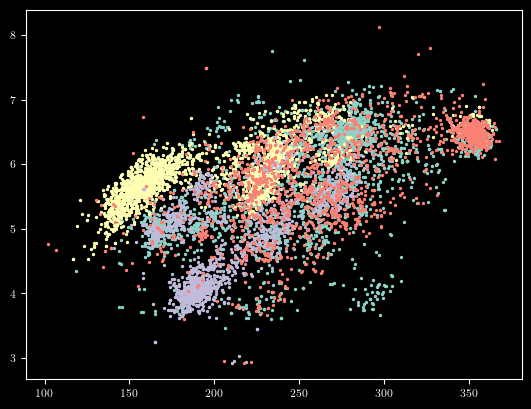

In [24]:
from sklearn.mixture import GaussianMixture
n_clusters = 4

_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length', 'energy', 'ca_distance']

tor_df = SS_df[_cols]
tor_df.head(1)
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(tor_df)
cluster_labels = gmm_model.predict(tor_df)
X = pd.DataFrame(tor_df)
X['cluster'] = cluster_labels
for k in range(n_clusters):
    data = X[X['cluster'] == k]
    plt.scatter(data['torsion_length'], data['ca_distance'], s=2)

plt.show()



In [ ]:
SS_df.head()

In [ ]:
# takes over an hour for full dataset
from sklearn.cluster import SpectralClustering
import seaborn as sns

_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length']
#cols = ['ca_distance', 'chi3', 'energy', 'torsion_length']

# tor_df = SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5']].copy()

tor_df = SS_df[_cols].copy()

X = tor_df
n_clusters = 4

scm_model = SpectralClustering(n_clusters=n_clusters, random_state=25,
                                n_neighbors=8, affinity='nearest_neighbors')
# takes 51 min with full dataset
X['cluster'] = scm_model.fit_predict(X[['torsion_length']])

fig, ax = plt.subplots()
ax.set(title='Spectral Clustering')
sns.scatterplot(x='chi3', y='torsion_length', data=X, hue='cluster', ax=ax, size=2)


/Users/egs/miniforge3/envs/proteus/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



<AxesSubplot: title={'center': 'Affinity Propagation'}, xlabel='chi1', ylabel='chi5'>

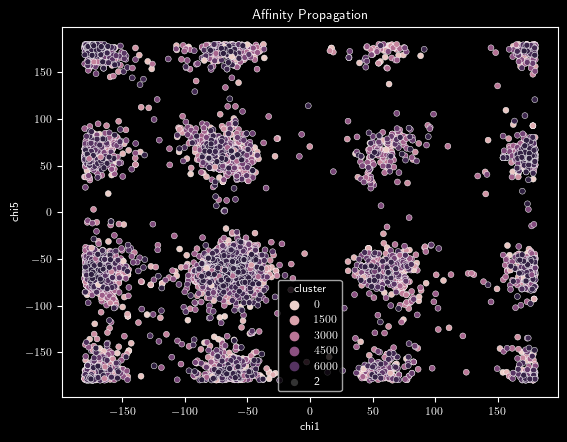

In [26]:
# takes over an hour for full dataset
from sklearn.cluster import AffinityPropagation
import seaborn as sns
n_clusters = 8

_cols = ['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length']
tor_df = SS_df[_cols].copy()

X = tor_df.copy()

aff_model = AffinityPropagation(max_iter=100, random_state=25)
# takes 51 min with full dataset
X['cluster'] = aff_model.fit_predict(X[['torsion_length']])

fig, ax = plt.subplots()
ax.set(title='Affinity Propagation')
sns.scatterplot(x='chi1', y='chi5', data=X, hue='cluster', ax=ax, size=2)


/var/folders/pz/2mvcdsnx3jb9cs_vscydtld00000gs/T/ipykernel_29949/1464808019.py:17: UserWarning:

The palette list has more values (16) than needed (4), which may not be intended.



<AxesSubplot: title={'center': 'Agglomerative Clustering'}, xlabel='chi1', ylabel='chi5'>

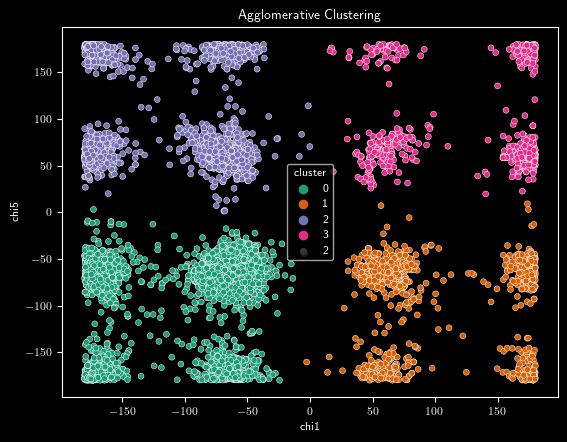

In [31]:
# takes over an hour for full dataset
from sklearn.cluster import AgglomerativeClustering
n_clusters = 16
custom_palette = sns.color_palette("Dark2", n_clusters)

n_clusters = 4

tor_df = SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'torsion_length']].copy()
X = tor_df.copy()

agg_model = AgglomerativeClustering(n_clusters=n_clusters)

X['cluster'] = agg_model.fit_predict(X[['chi1', 'chi5']])

fig, ax = plt.subplots()
ax.set(title='Agglomerative Clustering')
sns.scatterplot(x='chi1', y='chi5', data=X, hue='cluster', ax=ax, size=2, palette=custom_palette)


In [ ]:
labels = {'value': 'Chi3', 'variable': 'Variable'}

x = SS_df['chi3']
y = SS_df['energy']
df = SS_df[['chi3', 'energy']].copy()

energy_hist = numpy.histogram2d(x, y=y, bins=360)
energy_hist = energy_hist

fig = px.histogram(df, labels=labels)

fig.show()

In [ ]:
cols = ['chi1', 'chi5']
px.histogram(SS_df[cols], labels=labels)

In [ ]:
cols = ['chi2', 'chi4']
px.histogram(SS_df[cols], labels=labels)

In [ ]:
px.histogram(SS_df['chi3'], labels=labels)

## Summary
Conformational analysis of 294,222 disulfide bonds in 36,362 proteins contained in the RCSB confirms the predominant conformational classes first described in my initial analysis:
- Left-Handed Spiral
- Right-Handed Hook
- Left-Handed Spiral
  

## Publications
* https://doi.org/10.1021/bi00368a023
* https://doi.org/10.1021/bi00368a024
* https://doi.org/10.1016/0092-8674(92)90140-8
* http://dx.doi.org/10.2174/092986708783330566

## Distribution of Backbone Dihedral Angles $\phi - \psi$

A protein's backbone conformation is defined by the dihdedral angles $\phi$ and $\psi$. The ```proteusPy.Disulfide.ExtractDisulfides()``` function computes these at time of Disulfide extraction.

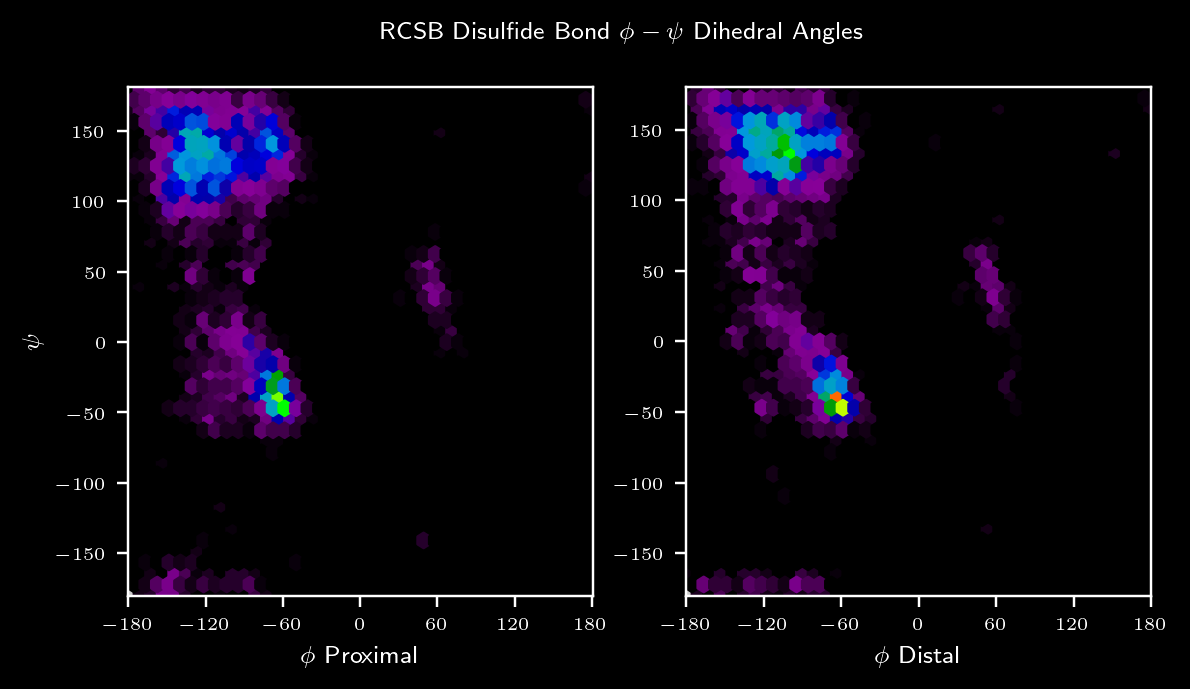

In [33]:
GRIDSIZE=40

x = SS_df['phi_prox']
y = SS_df['psi_prox']

x2 = SS_df['phi_dist']
y2 = SS_df['psi_dist']

plt.rcParams.update({'font.size': 8})
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(WIDTH, HEIGHT), dpi=DPI)

fig.suptitle(r'RCSB Disulfide Bond $\phi - \psi$ Dihedral Angles', fontsize=8)

ax1, ax2 = fig.subplots(1, 2, sharey=False)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xlim(TORMIN-1, TORMAX+1)
ax1.set_ylim(TORMIN-1, TORMAX+1)
ax1.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax1.set_xlabel(r'$\phi$ Proximal')
ax1.set_ylabel(r'$\psi$')

ax1.hexbin(x, y, gridsize=GRIDSIZE, cmap='nipy_spectral')

ax2.set_xlim(TORMIN, TORMAX)
ax2.set_ylim(-180, 180)
ax2.xaxis.set_ticks(numpy.arange(TORMIN-1, TORMAX+1, 60))

ax2.set_xlabel(r'$\phi$ Distal')
ax2.hexbin(x2, y2, gridsize=GRIDSIZE, cmap='nipy_spectral')

plt.show()

